In [2]:
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [4]:
import matplotlib.pyplot as plt

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import ast

In [6]:
import CleanTweets as ct

[nltk_data] Downloading package stopwords to /Users/Lono/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Lono/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
from nltk import bigrams
import itertools
import collections

In [67]:
african_names = pd.read_csv("africa_names.csv", names = ["names", "nan"])
fix_list = african_names["names"].to_list()

In [9]:
def get_wordcloud(df, text_col):# Generate a word cloud image
    wordcloud = WordCloud(background_color="white", width=1500, height=800).generate(' '.join(df[text_col]))

    # Display the generated image:

    plt.figure(figsize=(18,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [10]:
def draw_network(df, text_col, max_similarity):
    
    cv = CountVectorizer(ngram_range=(1,1), stop_words = 'english') # You can define your own parameters
    X = cv.fit_transform(df[text_col])
    Xc = (X.T * X) # Cosine similarity of words

    names = cv.get_feature_names() # This are the entity names (i.e. keywords)
    df_co = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)

    a = df_co.stack().reset_index()
    a.columns = ['source', 'target','value']
    a_filtered=a.loc[ (a['value'] > max_similarity) & (a['source'] != a['target']) ]


    # Build your graph
    plt.figure(figsize=(20,10))
    G=nx.from_pandas_edgelist(a_filtered, 'source', 'target')

    # Plot the network:
    # pos = graphviz_layout(G)
    nx.draw(G, with_labels=True, node_color='orange', node_size=50, edge_color='green', linewidths=2, font_size=15)

In [11]:
# https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/
def draw_cooccur_network(df, top_n_bigrams, col, title):
    terms_bigram = [list(bigrams(doc.split())) for doc in df[col]]
    bigramsls = list(itertools.chain(*terms_bigram))
    bigram_counts = collections.Counter(bigramsls)
    bigram_df = pd.DataFrame(bigram_counts.most_common(top_n_bigrams),
                                 columns=['bigram', 'count'])
    d = bigram_df.set_index('bigram').T.to_dict('records')

    # Create network plot 
    G = nx.Graph()

    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))

    fig, ax = plt.subplots(figsize=(15, 8))
    pos = nx.spring_layout(G, k=2)

    # Plot networks
    nx.draw_networkx(G, pos,
                     font_size=12,
                     width=3,
                     edge_color='grey',
                     node_color='purple',
                     with_labels = False,
                     ax=ax)

    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+.045, value[1]+.045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.2),
                horizontalalignment='center', fontsize=13)
    plt.title(title)
    plt.show()

# Publications

## 1. Time/volume - line chart

In [11]:
df = pd.read_csv('data/td_pulications.csv', index_col=0)

In [12]:
df['pub_year'] = df['bib'].apply(lambda x: ast.literal_eval(x)['pub_year'])
df_not_nan = df[df['pub_year']!= 'NA']

Note we lose a couple of publications because a number of them do not have publication year attached

In [13]:
#df_not_nan['pub_year'] = pd.to_datetime(df_not_nan['pub_year'])
df_not_nan['pub_year'] = df_not_nan['pub_year'].astype(int)
df_groupedby_date = df_not_nan.groupby('pub_year').count()
df_groupedby_date.reset_index(inplace=True)

/Users/Lono/miniconda3/envs/ethnicenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
df_groupedby_date['count'] = df_groupedby_date['container_type']

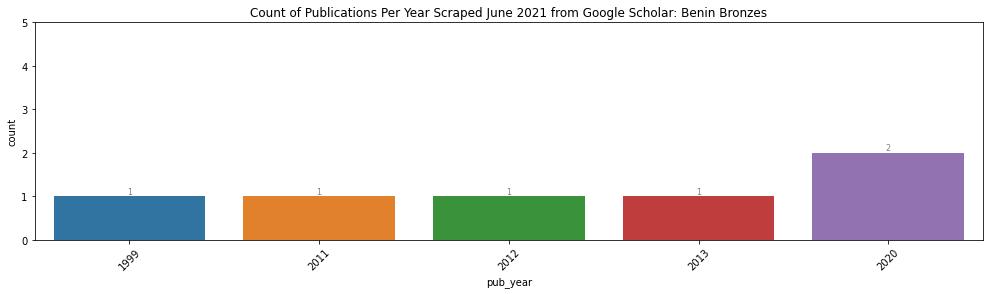

In [16]:
plt.figure(figsize=[17,4])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Year Scraped June 2021 from Google Scholar: Benin Bronzes')
g = sns.barplot(data=df_groupedby_date, 
             x="pub_year", 
             y="count") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,5) #To make space for the annotations

In [17]:
df_groupedby_date_2016 = df_groupedby_date[df_groupedby_date['pub_year'] > 2015]

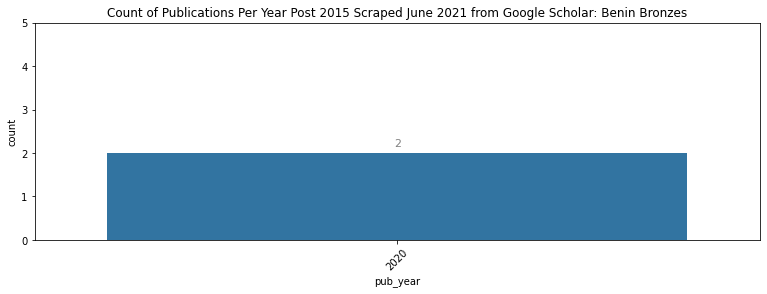

In [18]:
plt.figure(figsize=[13,4])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Year Post 2015 Scraped June 2021 from Google Scholar: Benin Bronzes')
g = sns.barplot(data=df_groupedby_date_2016, 
             x="pub_year", 
             y="count")
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')
_ = ax.set_ylim(0,5) #To make space for the annotations

## 2. Keywords - Network diagram

In [19]:
def get_abstract(x):
    try:
        return ast.literal_eval(x)['abstract']
    except KeyError:
        return ''

In [20]:
df['abstract'] = df['bib'].apply(lambda x: get_abstract(x) )
df_abs = df[df['abstract']!= '']

We lose around 100 publications because they do not have abstracts

In [21]:
df_abs = ct.clean_tweets(df_abs,'abstract','lemma_text',
                general_clean=True,lemma=True,stem=False,remove_tag=False,remove_mention=False,
                remove_emoji=False, remove_stopword=True,min_length=1, untokenized_return=True)

time taken to clean tweets: 2.297229051589966s. Use the [lemma_text] column to perform your analysis/modeling on


In [22]:
df_abs = ct.clean_tweets(df_abs,'abstract','stem_text',
                general_clean=True,lemma=False,stem=True,remove_tag=False,remove_mention=False,
                remove_emoji=False, remove_stopword=True,min_length=1, untokenized_return=True)

time taken to clean tweets: 0.05427908897399902s. Use the [stem_text] column to perform your analysis/modeling on


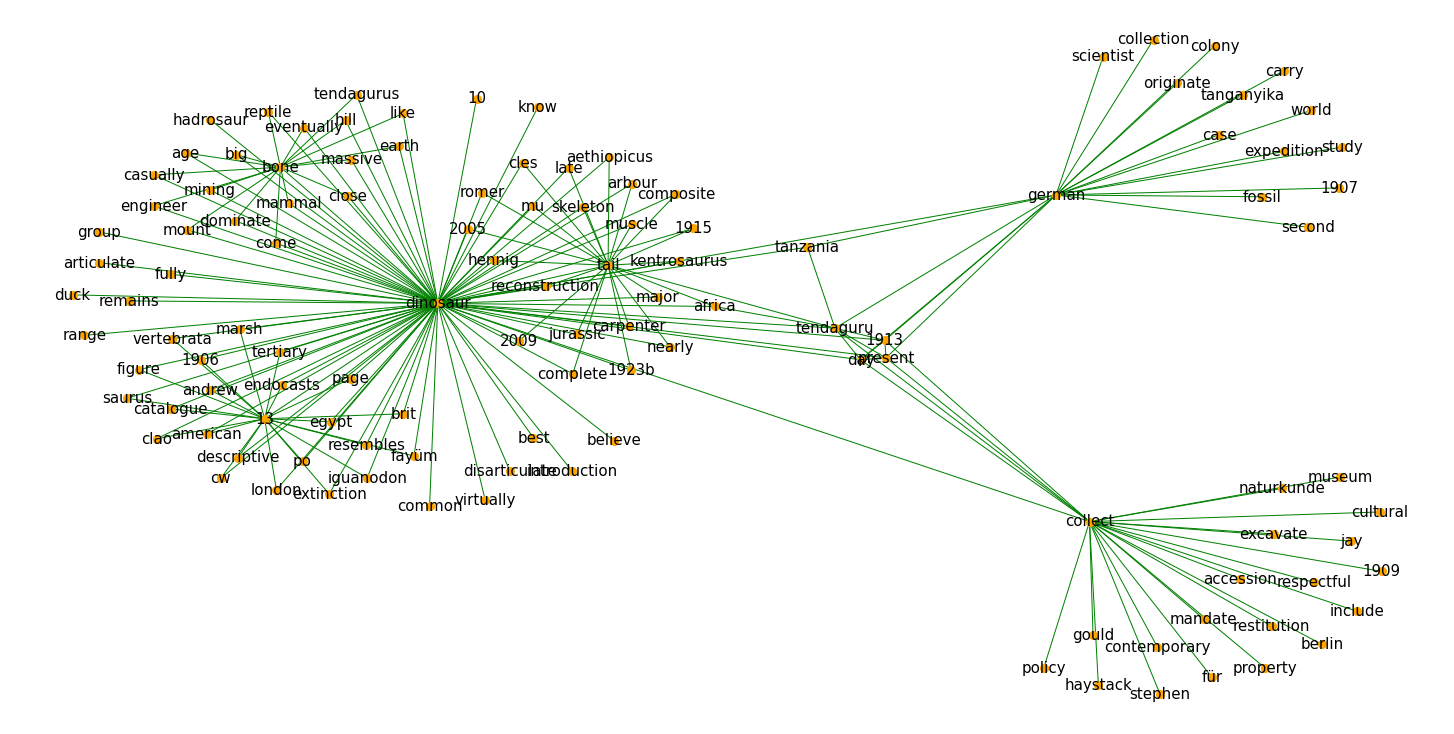

In [27]:
draw_network(df_abs, 'lemma_text', 1) 

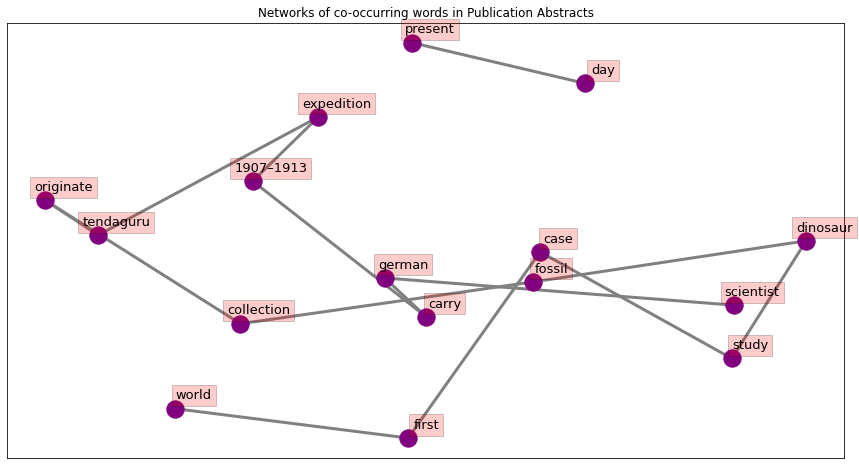

In [29]:
draw_cooccur_network(df_abs, 15,'lemma_text', 'Networks of co-occurring words in Publication Abstracts')

## 3. Peoples vs citations vs ethnicity - CSV list, network diagram

In [12]:
from ethnicolr import pred_wiki_ln, pred_wiki_name

Using TensorFlow backend.


In [13]:
import unicodedata

In [14]:
def clean_name(name, surname=False):
    if surname == True:
        res = name.split(' ')[1:]
        surname = ' '.join(chars for chars in res)
        if surname == '':
            surname = name.split(' ')[0]
        name = surname
            
    name = name.lower()
    #remove phonetics
    name = ''.join((c for c in unicodedata.normalize('NFD', name) if unicodedata.category(c) != 'Mn'))
    return name

### Authors African vs Not

In [33]:
df = pd.read_csv('data/td_pulications.csv', index_col=0)

In [34]:
df.shape

(8, 13)

In [35]:
df['author'] = df['bib'].apply(lambda x: ast.literal_eval(x)['author'])

In [36]:
df['count'] = 1
dummy = df[['author', 'count']]
dummy1 = dummy.set_index('count').author.apply(pd.Series).stack().reset_index(level=0).rename(columns={0:'author'})

In [37]:
dummy1['author'] = dummy1['author'].apply(lambda x: clean_name(x) )

In [38]:
res = dummy1.groupby('author').agg('sum').reset_index().sort_values('count',ascending=False)
res['surname'] = res['author'].apply(lambda x: clean_name(x, True))

In [39]:
preds = pred_wiki_ln(res, "surname")
preds['african'] = preds['race'].apply(lambda x: 'African' if x=='GreaterAfrican,Africans' else ('African' if x== 'GreaterAfrican,Muslim' else 'Non-African'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




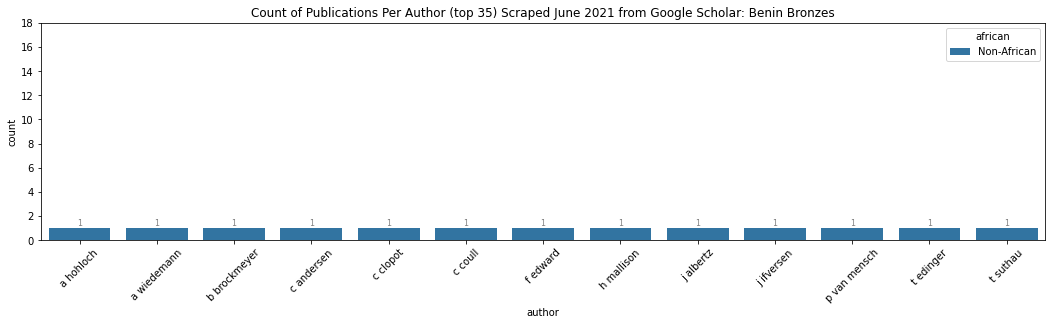

In [44]:
for name in fix_list:
    preds.loc[preds['surname']==name, 'african'] = 'African'
    
plt.figure(figsize=[18,4])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Author (top 35) Scraped June 2021 from Google Scholar: Benin Bronzes')
g = sns.barplot(data=preds[0:35], 
             x="author", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,18) #To make space for the annotations

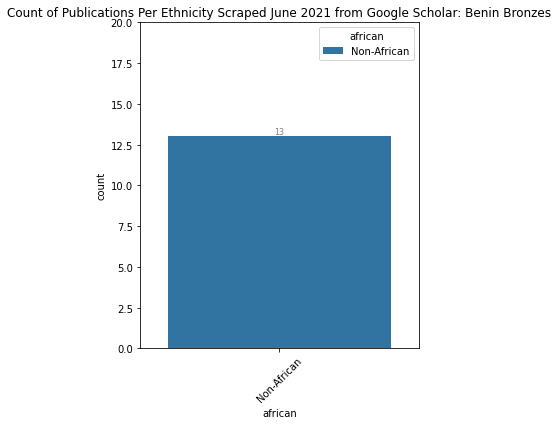

In [46]:
ratio = preds.groupby('african').agg('sum').reset_index()
plt.figure(figsize=[5,6])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Ethnicity Scraped June 2021 from Google Scholar: Benin Bronzes')
g = sns.barplot(data=ratio, 
             x="african", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,20) #To make space for the annotations

# Media 

In [147]:
from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [189]:
df = pd.read_csv('data/td_google_content313.csv', index_col=0)
df.shape

(122, 4)

Remove pdfs

In [190]:
df = df[~df['link'].str.contains('.pdf')]
df.shape

(89, 4)

Get the remainder of pdfs

In [191]:
df_text = df[~df['text'].astype(str).str.contains("�����")]
df_text.shape

(87, 4)

Remove null texts

In [192]:
df_text = df_text[~df_text['text'].isna()]
df_text.shape

(70, 4)

Remove special links

In [193]:
# whole encyclopedia volume that mentions Tendaguru once
links_to_remove = ['https://docplayer.fr/10395969-1661-5468-vol-33-n-1-2014.html']
# also an encyclopedia volume that mentions Tendaguru once
links_to_remove.append('https://archive.org/stream/encyclopdiabri32newyrich/encyclopdiabri32newyrich_djvu.txt')
# absolutely irrelevant
links_to_remove.append('https://github.com/lopopolo/sr/blob/master/test/datadumps/experiment-7-run-4.json')

# about dinosaurs not restituion, many many words, mentions Tendaguru Formation
links_to_remove.append('https://www.science.gov/topicpages/b/bone+size+variation')

# Tendaguru does not appear
links_to_remove.append('https://worldwidescience.org/topicpages/e/early+precambrian+microfossils.html')

# lots of words Tendaguru mentioned once 
links_to_remove.append('https://geobrowser.de.dariah.eu/data/dbpedia/museum.kml')

# lots of words no restituion
links_to_remove.append('https://worldwidescience.org/topicpages/t/terrestrial+palynological+assemblages.html')

# lots of words no restitution
links_to_remove.append('https://dokumen.site/download/2012-eavp-abstracts-a5b39f10665dd5')

# too many words and has restitution only once
links_to_remove.append('https://ars.electronica.art/prix/en/jurystatement/')
links_to_remove.append('https://docplayer.net/152439676-Prize-19-s-t-arts-prix-ars-electronica-cyberarts-ars-electronica-art-technology-society.html')

# too may words mostly german
links_to_remove.append('https://mws.hypotheses.org/tag/reports/feed')

In [194]:
df_text = df_text[~df_text['link'].isin(links_to_remove)]
df_text.shape

(59, 4)

Remove videos

In [196]:
df_text = df_text[~df_text['link'].astype(str).str.contains("youtube")]
df_text.shape

(58, 5)

In [195]:
df_text['text_len'] = df_text['text'].apply(lambda x: len(x))

Remove html tags

In [197]:
df_text['text'] = df_text['text'].apply(lambda x: strip_tags(x))

#### NB: There are a lot of german articles that this analysis will miss

Remove german stop words

In [198]:
german_stop_words = stopwords.words('german')

In [199]:
df_text['text'] = df_text['text'].apply(lambda x: " ".join([item for item in x.split() if item not in german_stop_words])  )

In [215]:
df_text[df_text['text'].str.contains('schedule')].iloc[0].link

'https://www.dailynews.co.tz/news/2019-02-205c6cec953280b.aspx'

### 1. Keywords - Network diagram: Pelonomi

The green newtork diagrams are with regards to word similarity based on the texts

In [200]:
df_text = ct.clean_tweets(df_text,'text','lemma_text',
                general_clean=True,lemma=True,stem=False,remove_tag=False,remove_mention=False,
                remove_emoji=False, remove_stopword=True,min_length=1, untokenized_return=True)

time taken to clean tweets: 16.041471004486084s. Use the [lemma_text] column to perform your analysis/modeling on


### The first 15 articles. This is typically the first result page with half the next page

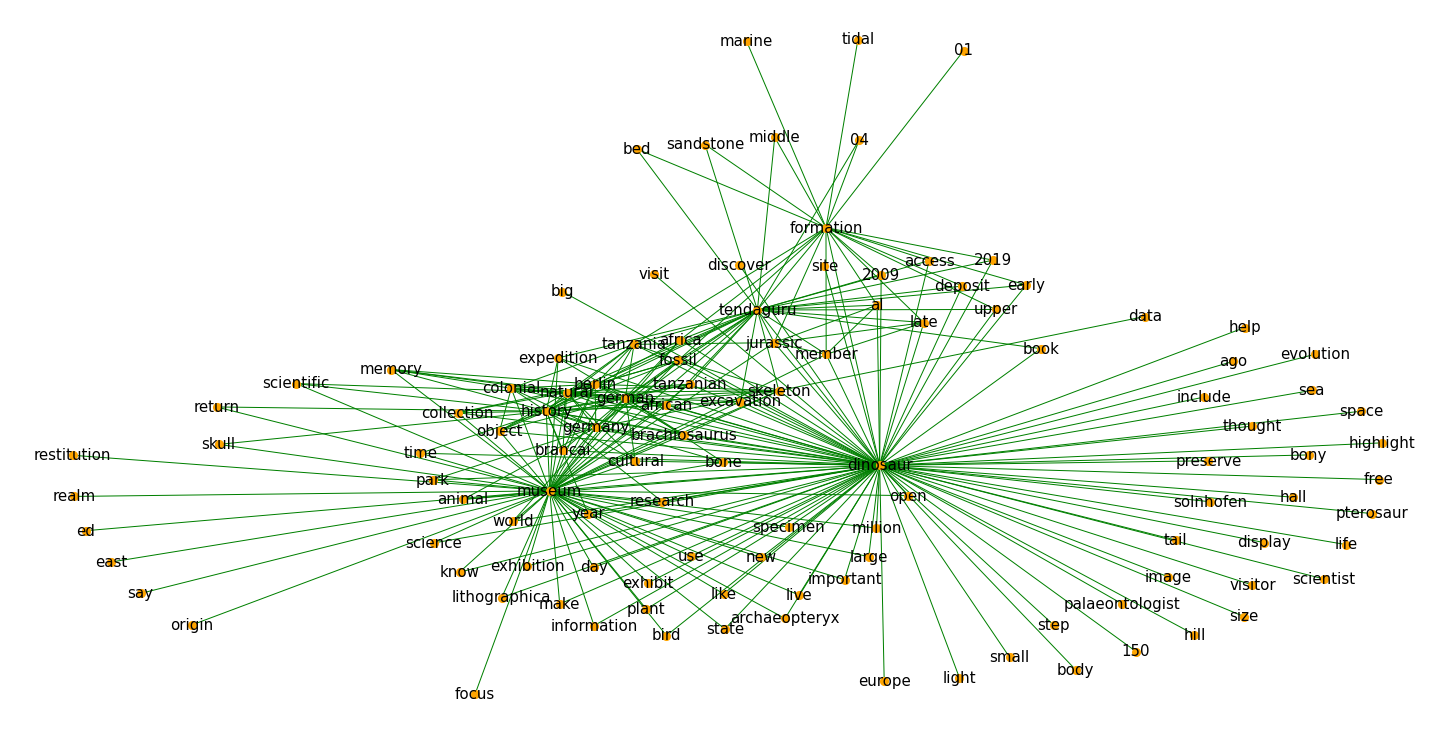

In [221]:
# great article had slides in it that were making my pictures ugly
slides_words = ['schedule', 'begin', 'end', 'slide']
df_text['lemma_text'] = df_text['lemma_text'].apply(lambda x: " ".join([item for item in x.split() if item not in slides_words]))
draw_network(df_text[:15], 'lemma_text', 1000) #5

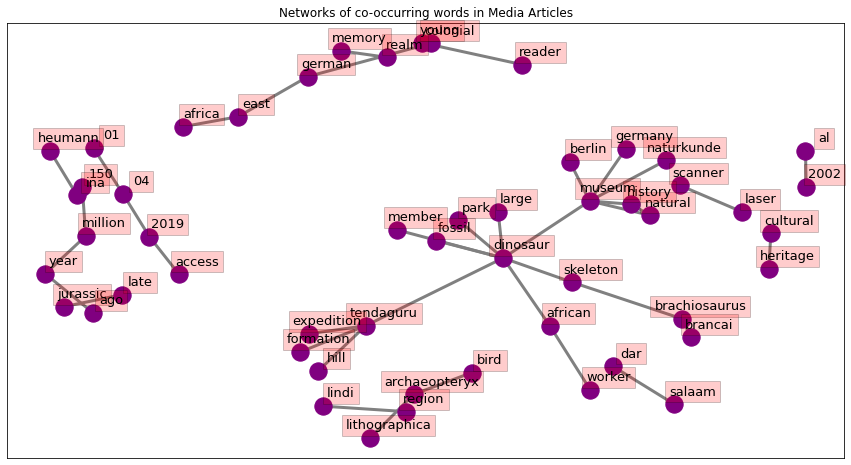

In [217]:
draw_cooccur_network(df_text[:15], 40,'lemma_text', 'Networks of co-occurring words in Media Articles')

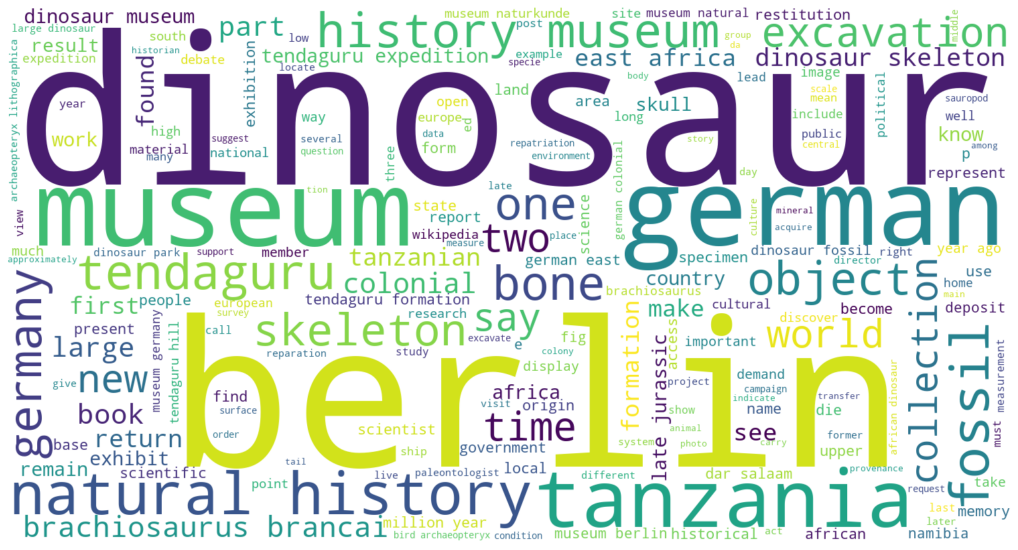

In [218]:
get_wordcloud(df_text[:15], 'lemma_text')

### All the articles

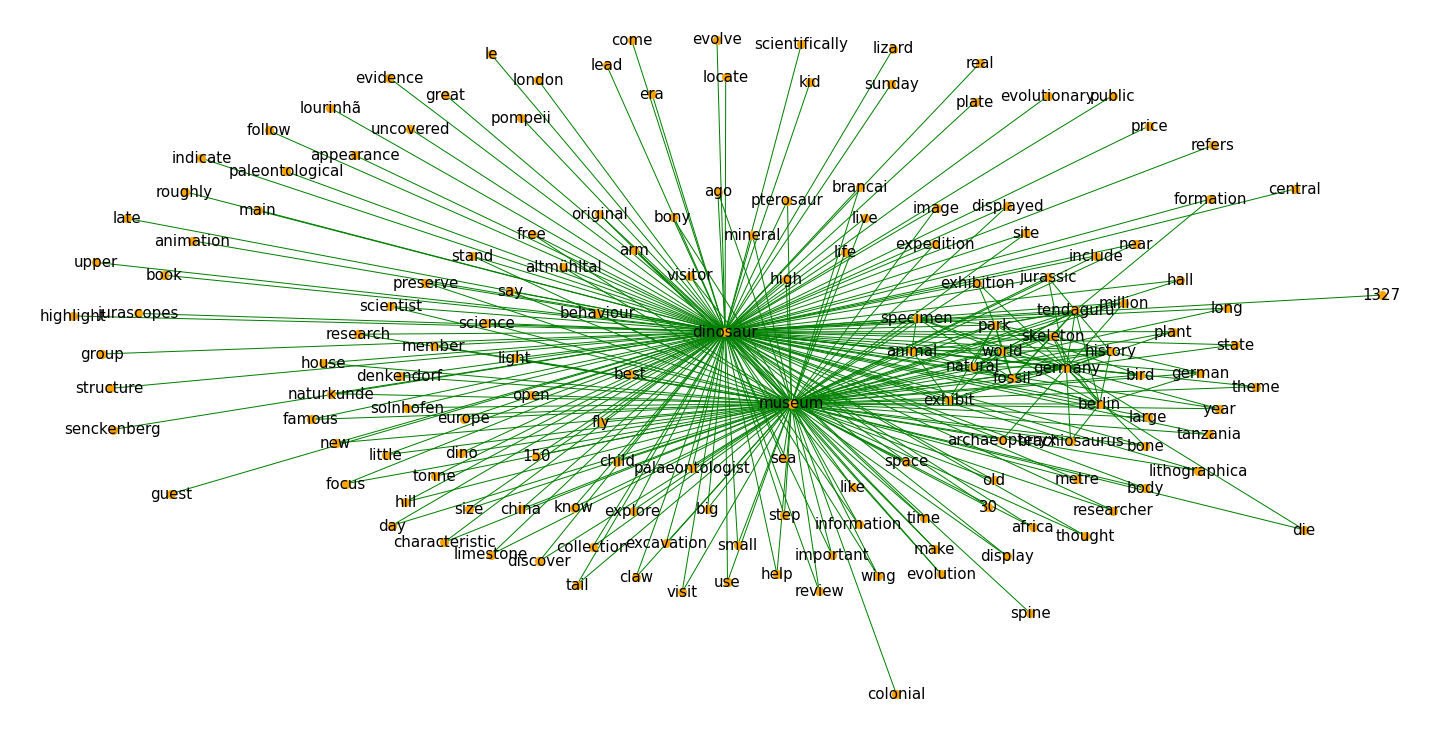

In [226]:
draw_network(df_text, 'lemma_text', 3300) #5

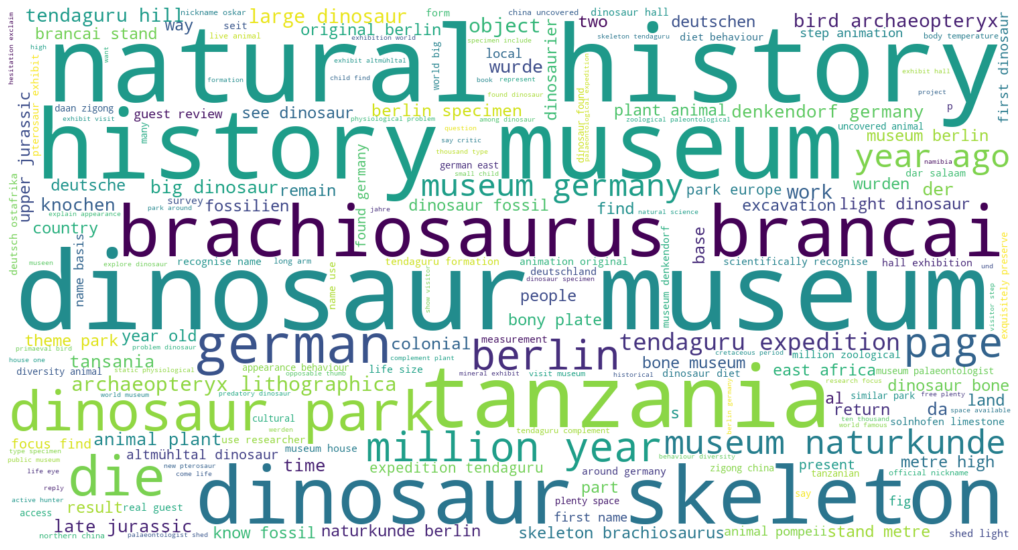

In [223]:
get_wordcloud(df_text, 'lemma_text')

In [227]:
df_text.to_csv('tendaguru_google_text_manual_clean.csv')

### 2. Peoples vs mentions vs ethnicity - CSV list, bar chart: Pelonomi

In [ ]:
#this section requires Spacy
#!pip install spacy
#!python -m spacy download en_core_web_sm

#### Get names first

In [29]:
import spacy

In [30]:
from nltk.corpus import stopwords

In [31]:
def NER(text):
    """Takes in a string of text and returns a dataframe of all named entities
    
        Args:
            :param text: string, a string containing entire corpus
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)

    entities = []
    labels = []
    position_start = []
    position_end = []

    for ent in doc.ents:
        entities.append(ent)
        labels.append(ent.label_)
        position_start.append(ent.start_char)
        position_end.append(ent.end_char)

    df = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})

    return df

In [32]:
df.sample(10)

,title,link,text,html_date
46,A three-dimensional skeleton of Goniopholidida...,https://docentes.fct.unl.pt/omateus/files/puer...,"�,��7�qX '�� ��$Ȃ""��&�'�/�??????���...",NaN
101,1072329 the 796860 of 593456 and 583962 in 326...,https://ad-teaching.informatik.uni-freiburg.de...,NaN,NaN
18,dinosaur museum germany - Coldys Corner,https://coldy.net.au/vanilla-sponge-hnyqgbq/a3...,NaN,NaN
40,Museen – Orte des Authentischen? Museums – Pla...,https://books.ub.uni-heidelberg.de/propylaeum/...,<413870A5AE2B5943BA4519BFA66338B0>]/Index[2265...,NaN
77,Germany moves slowly on returning museum exhib...,https://mediafocus.biz/germany-moves-slowly-on...,Berlin’s longest-status African is thirteen me...,2021-06-11
49,Loot.co.za: Sitemap,https://www.loot.co.za/index/html/index4491.html,NaN,NaN
35,General Catalogue,http://link.springer.com/content/pdf/10.1007%2...,General Catalogue | SpringerLink \n \n \n Skip...,NaN
97,dinosaur museum germany - Itsy Bitsy,https://blog.itsybitsy.in/rue-herb-utqxf/dinos...,Senckenberg Natural History Museum (Naturmuseu...,2021-04-20
56,"1 VULCANISING WORKS, - Papers Past",https://paperspast.natlib.govt.nz/imageserver/...,NaN,NaN
105,Prize'19 S+T+ARTS. Prix Ars Electronica. Cyber...,https://docplayer.net/152439676-Prize-19-s-t-a...,1 CyberArts 2019 Prix Ars Electronica S+T+ARTS...,2018-01-01


In [33]:
#there is a couple of nans in here (8 articles in total) including two Japanese articles hahaha
df = df[~df['text'].isna()]
text = ''.join(x for x in df['text'])

In [37]:
stopwords_eng = stopwords.words('english')
tokenized_doc = text.split()
no_stopwords = " ".join([item for item in tokenized_doc if item not in stopwords_eng])  

In [39]:
len(no_stopwords)

15637578

In [41]:
ner_df = NER(text[0:1000000])
ner_df2 = NER(text[1000000:2000000])
ner_df3 = NER(text[2000000:3000000])

In [49]:
ner_df4 = NER(text[3000000:4000000])
ner_df5 = NER(text[4000000:5000000])
ner_df6 = NER(text[5000000:6000000])

In [50]:
ner = pd.concat([ner_df, ner_df2, ner_df3, ner_df4, ner_df5, ner_df6])

In [51]:
ner['count'] = 1
ner.groupby('Entities').agg('sum').reset_index().sort_values('count',ascending=False)

,Entities,Position_Start,Position_End,count
0,"(Dinosaurs, of, Tendaguru)",0,22,1
44486,(three),657052,657057,1
44488,"(Mitarbeiterschaft, zusammensetzte)",657076,657108,1
44489,(Balfour),657090,657097,1
44490,"(Baron, Sonnino)",657099,657112,1
44491,(Makino),657120,657126,1
44492,(13),657164,657166,1
44493,"(BEF9997102216811871FA3C4B7966605, \n )",657169,657204,1
44494,"(the, end, of, June)",657174,657189,1
44495,"(Ein, Amerikaner)",657182,657196,1


In [52]:
ner = ner[(ner['Labels'] == 'PERSON')]

In [53]:
ner['Entities'] = ner['Entities'].astype(str)
ner = ner.groupby('Entities').agg('sum').reset_index().sort_values('count',ascending=False)

In [58]:
exl_list = ['Benin', 'British', 'Museums', 'Benin Bronze', 'Benin Bronzes', 'Museum', 'Tendaguru', 
            'Bone', 'Copyright ©', 'Dinosaurs']
ner = ner[~ner['Entities'].isin(exl_list)]
ner.head(40)

,Entities,Position_Start,Position_End,count
10066,Wilson,36170504,36170834,55
6857,Miocene,27562923,27563266,49
3317,Fig,24757757,24757904,49
4536,J.,22498532,22498616,42
5740,L.,24896539,24896623,42
6110,Liu,17032766,17032883,39
1459,Buffetaut,20362801,20363152,39
6047,Li,16595692,16595762,35
6573,Martin,12969697,12969883,31
3844,Giraffatitan,7623231,7623603,31


In [ ]:
ner[['Entities', 'count']].to_csv('td_media_people_mentions.csv')

I wrote to file here, started the ethnic env then read in the file and continued

In [9]:
ner = pd.read_csv('td_media_people_mentions.csv', index_col=0)

In [60]:
ner['surname'] = ner['Entities'].apply(lambda x: clean_name(x, True))

In [61]:
preds2 = pred_wiki_ln(ner, "surname")





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [62]:
preds2

,Entities,Position_Start,Position_End,count,surname,race,"Asian,GreaterEastAsian,EastAsian","Asian,GreaterEastAsian,Japanese","Asian,IndianSubContinent","GreaterAfrican,Africans","GreaterAfrican,Muslim","GreaterEuropean,British","GreaterEuropean,EastEuropean","GreaterEuropean,Jewish","GreaterEuropean,WestEuropean,French","GreaterEuropean,WestEuropean,Germanic","GreaterEuropean,WestEuropean,Hispanic","GreaterEuropean,WestEuropean,Italian","GreaterEuropean,WestEuropean,Nordic"
10066,Wilson,36170504,36170834,55,wilson,"GreaterEuropean,British",0.003947,0.008102,1.969660e-03,0.003005,0.000546,0.877515,0.002188,0.041132,0.011847,2.108289e-03,3.384637e-02,7.575717e-03,6.219115e-03
6857,Miocene,27562923,27563266,49,miocene,"GreaterEuropean,British",0.004924,0.009216,8.716812e-04,0.020818,0.005719,0.337936,0.024336,0.064359,0.156678,2.395437e-03,1.742343e-01,1.962840e-01,2.227743e-03
3317,Fig,24757757,24757904,49,fig,"GreaterEuropean,WestEuropean,Germanic",0.016770,0.005531,3.515640e-02,0.003972,0.052138,0.222218,0.083934,0.116046,0.063709,2.811241e-01,3.840964e-02,2.594177e-02,5.504990e-02
4536,J.,22498532,22498616,42,j.,"GreaterEuropean,British",0.036230,0.203203,7.137376e-03,0.012934,0.027555,0.523372,0.007606,0.061629,0.015351,2.158317e-02,3.177024e-02,2.448926e-02,2.713885e-02
5740,L.,24896539,24896623,42,l.,"GreaterEuropean,British",0.160503,0.009721,1.900052e-03,0.003323,0.005521,0.555794,0.038807,0.026785,0.121127,1.318369e-02,9.666463e-03,3.707970e-02,1.659036e-02
6110,Liu,17032766,17032883,39,liu,"Asian,GreaterEastAsian,EastAsian",0.985252,0.003318,3.551957e-04,0.001338,0.000393,0.001119,0.000557,0.000402,0.000313,1.744825e-04,2.101325e-04,5.909662e-03,6.591572e-04
1459,Buffetaut,20362801,20363152,39,buffetaut,"GreaterEuropean,WestEuropean,French",0.000361,0.000046,1.538796e-04,0.000590,0.000242,0.072580,0.006447,0.004098,0.866400,5.025006e-03,1.681760e-02,2.717385e-02,6.589435e-05
6047,Li,16595692,16595762,35,li,"Asian,GreaterEastAsian,EastAsian",0.954880,0.000561,5.438740e-04,0.000201,0.002664,0.019958,0.001368,0.006346,0.001435,1.681231e-03,1.048775e-03,3.085177e-03,6.227328e-03
6573,Martin,12969697,12969883,31,martin,"GreaterEuropean,British",0.001149,0.001757,2.372900e-02,0.001923,0.002515,0.709355,0.008584,0.008822,0.191691,3.075734e-03,1.536890e-02,2.663749e-02,5.393437e-03
3844,Giraffatitan,7623231,7623603,31,giraffatitan,"GreaterEuropean,WestEuropean,Italian",0.005073,0.014055,1.404648e-01,0.019844,0.023838,0.083718,0.075576,0.098906,0.084534,9.748830e-03,1.314098e-01,3.110769e-01,1.755095e-03


In [63]:
ner.groupby('surname').agg('sum').reset_index().sort_values('count', ascending=False)

,surname,Position_Start,Position_End,count
2,\n,114257309,114261263,232
3968,j.,53688854,53689363,98
4648,l.,47896061,47896472,83
342,a.,32812395,32812895,64
8348,wilson,38322054,38322420,59
2803,et al.,18301279,18302095,56
5535,miocene,29733618,29734004,52
1434,buffetaut,25175173,25175676,50
3105,g.,25138295,25138501,49
2942,fig,24757757,24757904,49


In [64]:
preds2['african'] = preds2['race'].apply(lambda x: 'African' if x=='GreaterAfrican,Africans' else ('African' if x== 'GreaterAfrican,Muslim' else 'Non-African'))

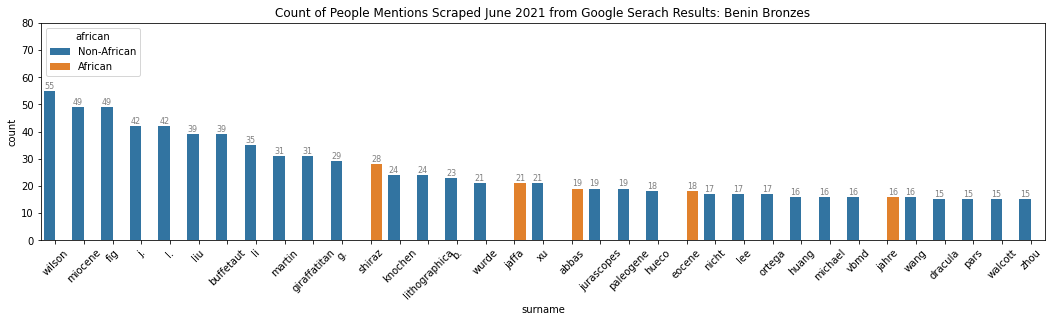

In [68]:
#manual fixes
for name in fix_list:
    preds2.loc[preds2['surname']==name, 'african'] = 'African'
    
plt.figure(figsize=[18,4])
plt.xticks(rotation=45)
plt.title('Count of People Mentions Scraped June 2021 from Google Serach Results: Benin Bronzes')
g = sns.barplot(data=preds2[0:35], 
             x="surname", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,80) #To make space for the annotations

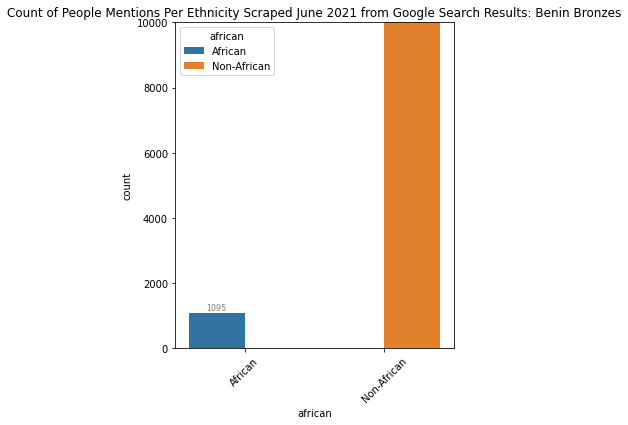

In [72]:
ratio = preds2.groupby('african').agg('sum').reset_index()
plt.figure(figsize=[5,6])
plt.xticks(rotation=45)
plt.title('Count of People Mentions Per Ethnicity Scraped June 2021 from Google Search Results: Benin Bronzes')
g = sns.barplot(data=ratio, 
             x="african", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,10000) #To make space for the annotations

TODO: need to fix this because there are some times where only the surname is mentioned, need to group by on that before getting the ethnicity to get a proper representation of the numbers